# Mini Image Segmentation Assignment

## Step-1 Data Loading and Preprocessing
<b>Purpose</b>: In this section, I load the images and corresponding binary masks to prepare the data for training.
>- <b>Image and Mask Resizing</b>: I resize each image and mask to a fixed resolution (128x128 pixels) to ensure uniform input dimensions, which helps the model process data more efficiently and reduces computation time.
>- <b>Normalization</b>: I normalize pixel values to the [0, 1] range, making it easier for the model to learn by standardizing the input data.

In [1]:
# Import necessary libraries
import numpy as np
import os
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, models
import cv2
import matplotlib.pyplot as plt

# Define paths to image and mask folders
images_folder = r"C:\Users\91817\OneDrive\Dataset\images"  # Path for images
masks_folder = r"C:\Users\91817\OneDrive\Dataset\mask"     # Path for masks

# Parameters
IMG_SIZE = (128, 128)

# 1. Data Loading and Preprocessing
def load_images_and_masks(images_folder, masks_folder, img_size=(128, 128)):
    images = []
    masks = []
    
    image_files = sorted(os.listdir(images_folder))  # Sorted to match images and masks by order
    mask_files = sorted(os.listdir(masks_folder))
    
    for img_file, mask_file in zip(image_files, mask_files):
        img_path = os.path.join(images_folder, img_file)
        mask_path = os.path.join(masks_folder, mask_file)
        
        # Load and resize image
        img = cv2.imread(img_path, cv2.IMREAD_COLOR)
        img = cv2.resize(img, img_size)
        img = img / 255.0  # Normalize to [0, 1]
        images.append(img)
        
        # Load and resize mask
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        mask = cv2.resize(mask, img_size)
        mask = mask / 255.0  # Normalize to [0, 1]
        masks.append(mask)
    
    images = np.array(images)
    masks = np.array(masks).reshape(-1, img_size[0], img_size[1], 1)
    return images, masks

In [2]:
# Load and preprocess images and masks  
images, masks = load_images_and_masks(images_folder, masks_folder)

## Train-Test Split
- **Purpose**: Split the dataset into training and testing sets (70%-30%) to evaluate model performance on unseen data, ensuring it can generalize well.

In [3]:
#Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(images, masks, test_size=0.3, random_state=42)

## Step-2 Model Setup
### Purpose: This section focuses on building a basic segmentation model.
>- <b>Model Selection</b>: I use a U-Net architecture which is effective for image segmentation tasks as it captures both high-level and low-level features, which helps in accurately identifying object boundaries.
>- <b>Binary Output</b>: The model is designed to output a binary mask of the same dimensions as the input image, predicting each pixel as either foreground (object) or background.

In [4]:
# Define a simple U-Net model for segmentation
def unet_model(input_size=(128, 128, 3)):
    inputs = layers.Input(input_size)
    c1 = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(inputs)
    c1 = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(c1)
    p1 = layers.MaxPooling2D((2, 2))(c1)
    
    c2 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(p1)
    c2 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(c2)
    p2 = layers.MaxPooling2D((2, 2))(c2)
    
    c3 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(p2)
    c3 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c3)
    p3 = layers.MaxPooling2D((2, 2))(c3)
    
    c4 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(p3)
    c4 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c4)
    
    u6 = layers.UpSampling2D((2, 2))(c4)
    u6 = layers.concatenate([u6, c3])
    c6 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(u6)
    c6 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c6)
    
    u7 = layers.UpSampling2D((2, 2))(c6)
    u7 = layers.concatenate([u7, c2])
    c7 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(u7)
    c7 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(c7)
    
    u8 = layers.UpSampling2D((2, 2))(c7)
    u8 = layers.concatenate([u8, c1])
    c8 = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(u8)
    c8 = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(c8)
    
    outputs = layers.Conv2D(1, (1, 1), activation='sigmoid')(c8)
    model = models.Model(inputs=[inputs], outputs=[outputs])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

<b>Purpose</b> : Here, we train the model on the processed dataset to learn how to differentiate between foreground and background pixels.
>- <b>Epochs</b>: We limit the training to a few epochs (2-5) due to the small dataset size, allowing us to check if the model starts identifying basic patterns without overfitting.

In [5]:
# Initialize and train the model
model = unet_model()
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=5, batch_size=2)

Epoch 1/5
4/4 ━━━━━━━━━━━━━━━━━━━━ 72s 2s/step - accuracy: 0.5391 - loss: 0.6920 - val_accuracy: 0.5244 - val_loss: 0.6857
Epoch 2/5
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 240ms/step - accuracy: 0.6513 - loss: 0.6702 - val_accuracy: 0.5455 - val_loss: 0.6841
Epoch 3/5
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 226ms/step - accuracy: 0.5169 - loss: 0.6992 - val_accuracy: 0.5213 - val_loss: 0.6739
Epoch 4/5
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 211ms/step - accuracy: 0.5806 - loss: 0.6346 - val_accuracy: 0.5294 - val_loss: 0.6524
Epoch 5/5
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 232ms/step - accuracy: 0.6555 - loss: 0.6067 - val_accuracy: 0.7882 - val_loss: 0.5970


## Step-3 Prediction and Visualisation
<b>Purpose</b>: In this section, we evaluate the model’s performance on test images by generating predictions and visualizing the results.
>- <b>Original Image, Ground Truth Mask, and Predicted Mask</b>: By displaying these side-by-side, we can visually assess how well the model’s predicted mask aligns with the actual mask, giving insight into the model's accuracy in segmenting objects from the background

In [6]:
# Predict and visualize results
def plot_sample_predictions(model, X_test, y_test, num_samples=3):
    plt.figure(figsize=(10, num_samples * 5))
    for i in range(num_samples):
        idx = np.random.randint(0, len(X_test))
        test_image = X_test[idx]
        true_mask = y_test[idx]
        pred_mask = model.predict(test_image[np.newaxis, ...])[0]

        plt.subplot(num_samples, 3, i * 3 + 1)
        plt.imshow(test_image)
        plt.title("Original Image")

        plt.subplot(num_samples, 3, i * 3 + 2)
        plt.imshow(true_mask.squeeze(), cmap="gray")
        plt.title("Ground Truth Mask")

        plt.subplot(num_samples, 3, i * 3 + 3)
        plt.imshow(pred_mask.squeeze(), cmap="gray")
        plt.title("Predicted Mask")
    plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step


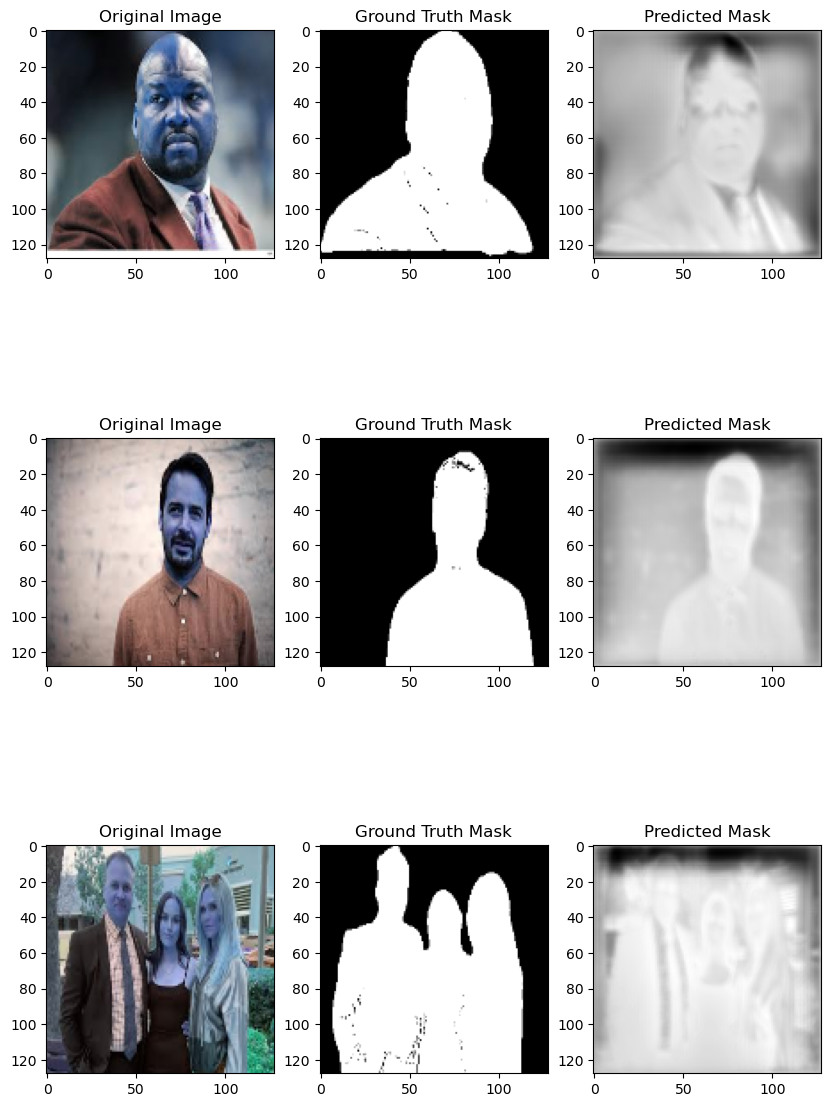

In [7]:
# Visualize predictions
plot_sample_predictions(model, X_test, y_test, num_samples=3)

## Acknowledgments:
>- Swift and precise generation of masks was possible through Remove bg's API.
>- images were downloaded from Google Image Search.